In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm

%config InlineBackend.figure_format='retina'

In [79]:
root = Path('./main/report/one_class')
semi_path = root / 'one_class_[1_-1_1]_[1_1_1]_[0.1]_[30]' / 'result_df_add.pkl'
un_path = root / 'one_class_unsupervised_[1_-1_1]_[]_[0.1]_[30]' / 'result_df_add.pkl'

In [80]:
semi_df = pd.read_pickle(semi_path)
un_df = pd.read_pickle(un_path)

In [81]:
semi_df_0 = semi_df[semi_df.labels == 0]['scores']
semi_df_1 = semi_df[semi_df.labels == 1]['scores']
un_df_0 = un_df[un_df.labels == 0]['scores']
un_df_1 = un_df[un_df.labels == 1]['scores']

> A few things to be noted: 
1. The synthetic normal class and abnormal class come from two different **gaussian distributions**.
2. The following anomaly scores are obtained on the **test set**.  
3. For the anomaly, it is assumed that training set and test set belong to the same class, i.e. there's **no distributional shift** in test.

# 1. Density Plot (PMF) for Anomaly Scores

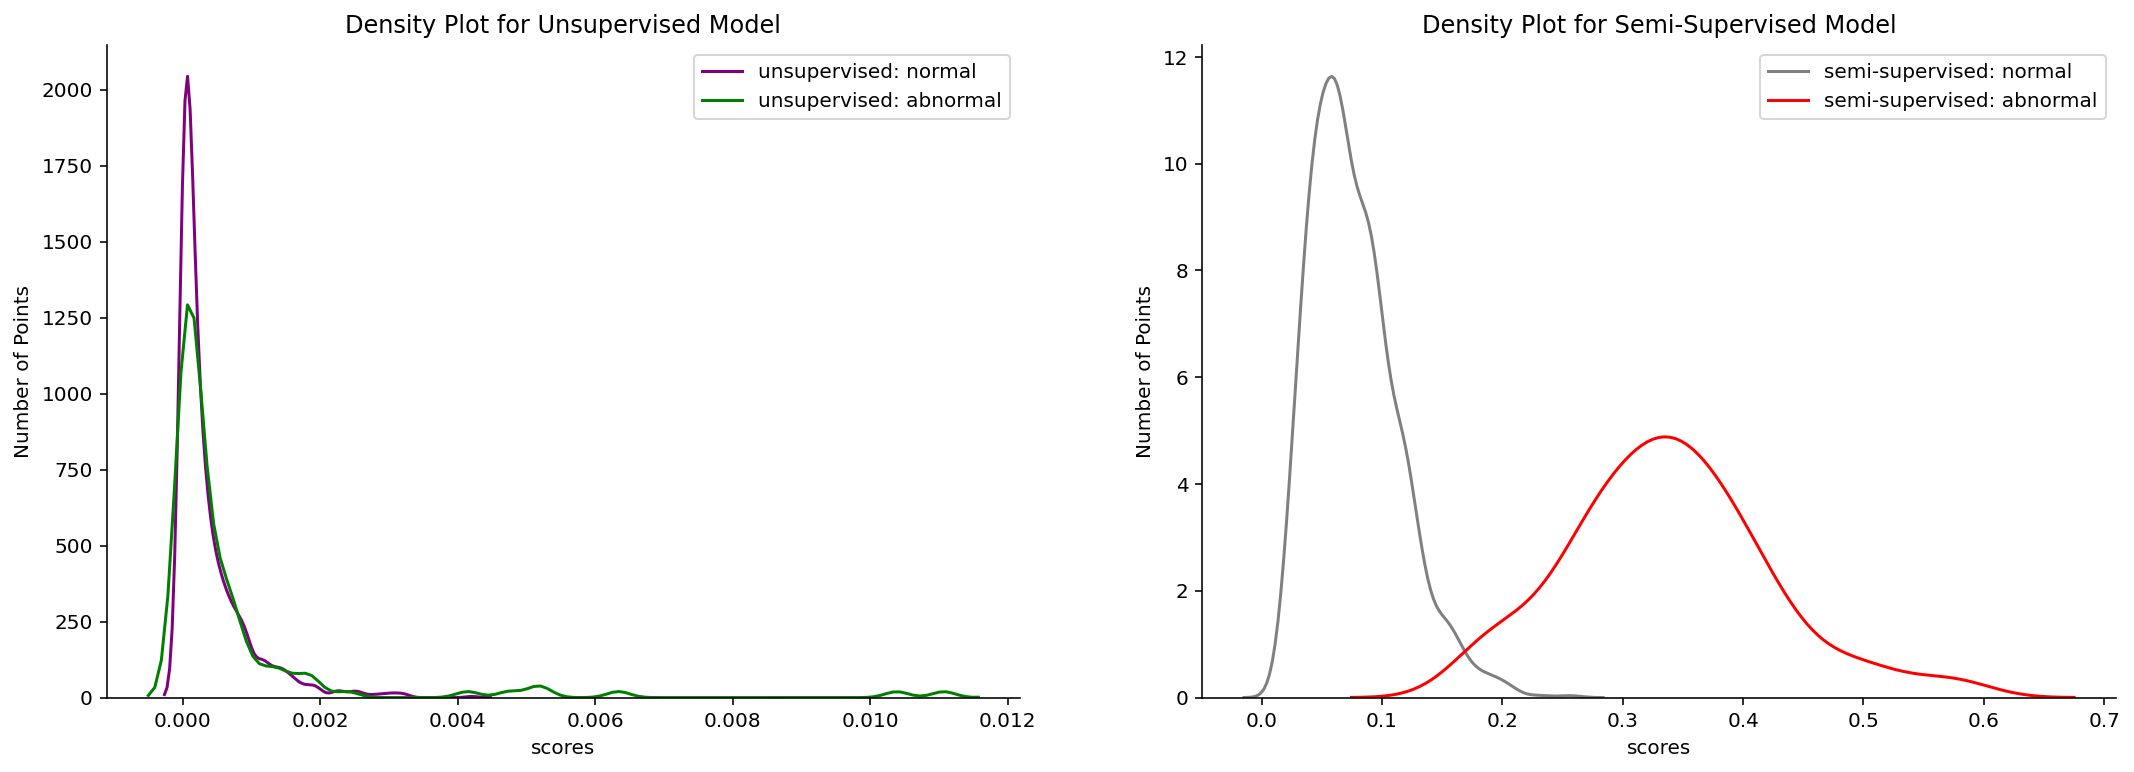

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(18, 6))

sea.distplot(un_df_0, hist=False, color='purple', label='unsupervised: normal', ax=ax1)
sea.distplot(un_df_1, hist=False, color='green', label='unsupervised: abnormal', ax=ax1)
ax1.set_title('Density Plot for Unsupervised Model')
ax1.set_ylabel('Number of Points')

sea.distplot(semi_df_0, hist=False, color='gray', label='semi-supervised: normal', ax=ax2)
sea.distplot(semi_df_1, hist=False, color='red', label='semi-supervised: abnormal', ax=ax2)
ax2.set_title('Density Plot for Semi-Supervised Model')
ax2.set_ylabel('Number of Points')
sea.despine()

# 2. CDF Plot for Anomaly Scores

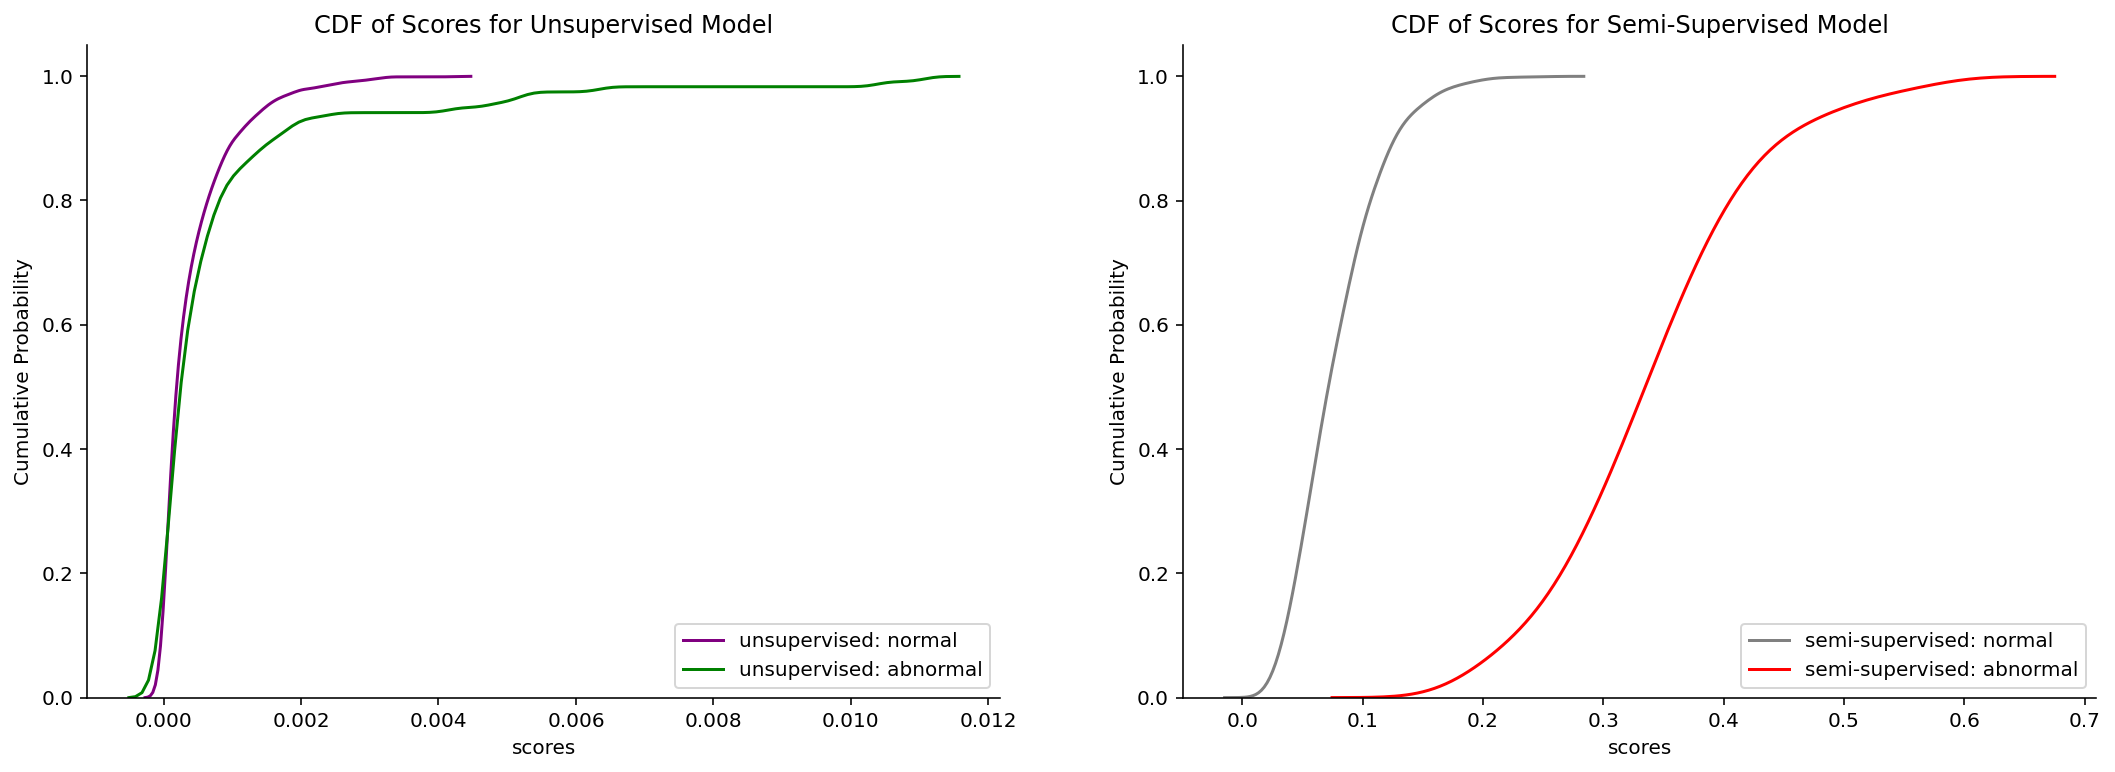

In [83]:
fig, (ax5, ax6) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(18, 6))

kws = {'cumulative': True}

sea.distplot(un_df_0, hist=False, color='purple', label='unsupervised: normal', kde_kws=kws, ax=ax5)
sea.distplot(un_df_1, hist=False, color='green', label='unsupervised: abnormal', kde_kws=kws, ax=ax5)
ax5.set_title('CDF of Scores for Unsupervised Model')
ax5.set_ylabel('Cumulative Probability')

sea.distplot(semi_df_0, hist=False, color='gray', label='semi-supervised: normal', kde_kws=kws, ax=ax6)
sea.distplot(semi_df_1, hist=False, color='red', label='semi-supervised: abnormal', kde_kws=kws, ax=ax6)
ax6.set_title('CDF of Scores for Semi-Supervised Model')
ax6.set_ylabel('Cumulative Probability')
sea.despine()

# 3. Density Plot for Score Differences

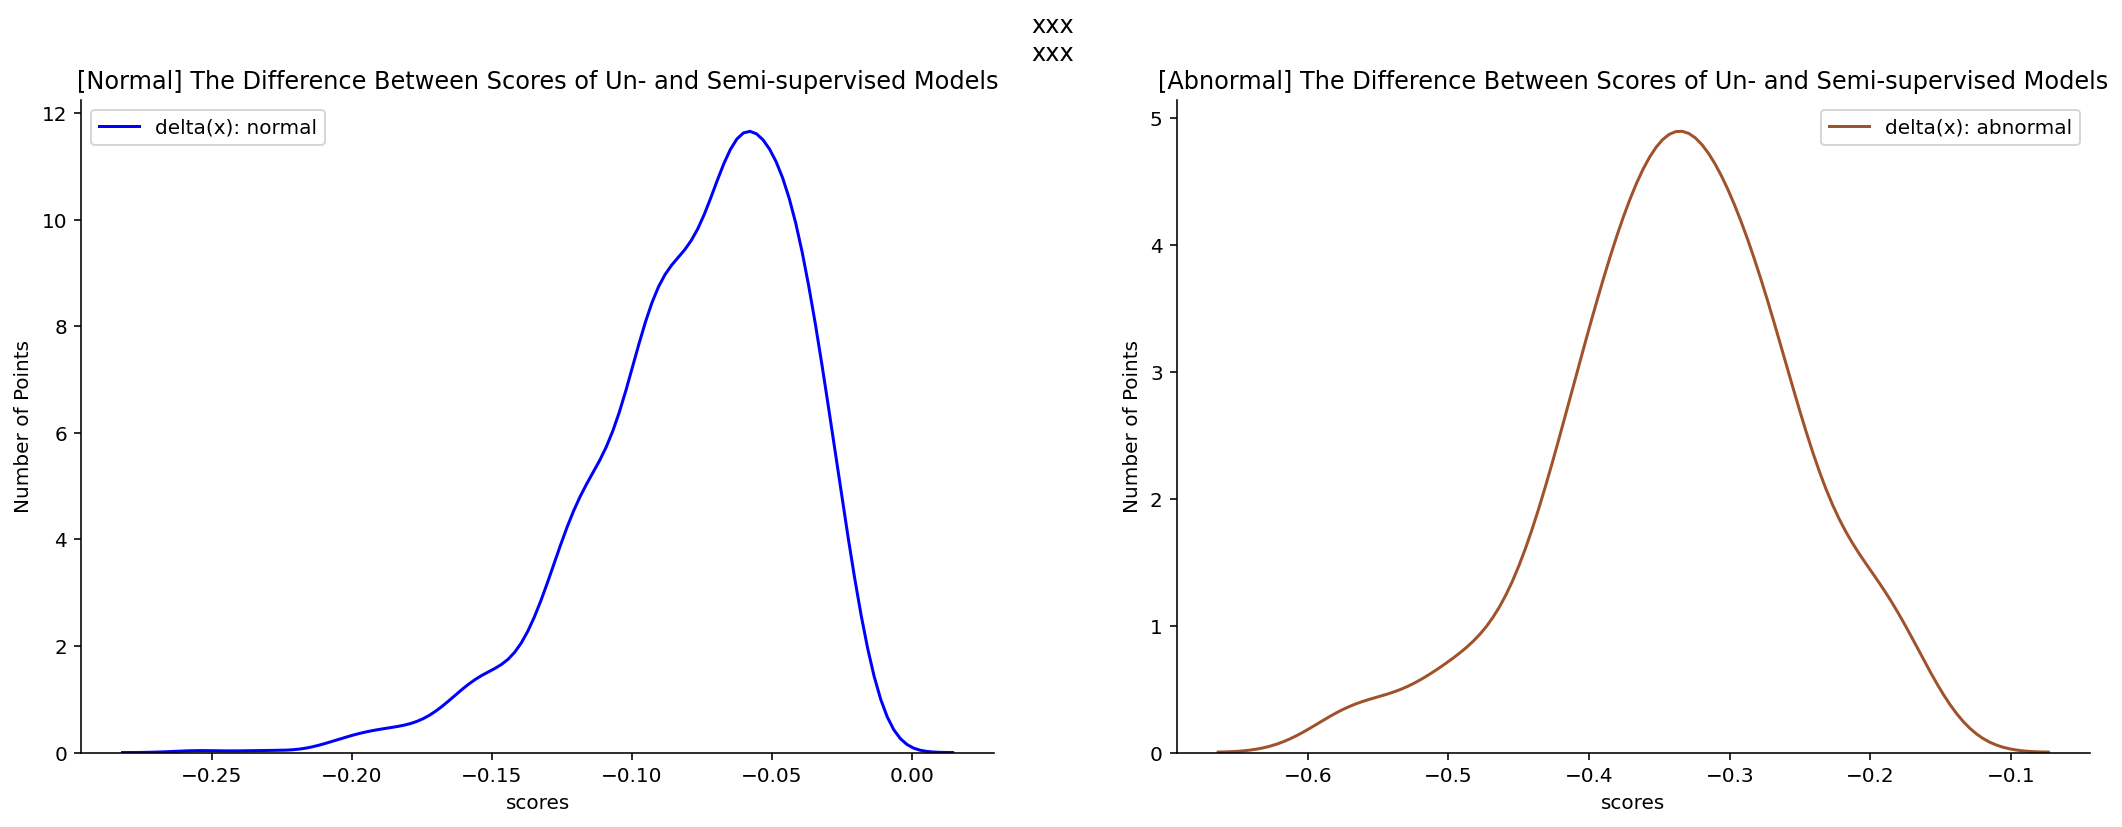

In [88]:
fig_, (ax3, ax4) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(18, 6))
sea.distplot(un_df_0 - semi_df_0, hist=False, color='blue', label='delta(x): normal', ax=ax3)
sea.distplot(un_df_1 - semi_df_1, hist=False, color='sienna', label='delta(x): abnormal', ax=ax4)

ax3.set_title('[Normal] The Difference Between Scores of Un- and Semi-supervised Models')
ax4.set_title('[Abnormal] The Difference Between Scores of Un- and Semi-supervised Models')
ax3.set_ylabel('Number of Points')
ax4.set_ylabel('Number of Points')
plt.suptitle('xxx\nxxx')
sea.despine()

> TODOS on the empirical side:
1. Need **more data** and **more experiments** to have a better estimate for the distribution of $\delta(x)$ (gaussian or other 2-parameter distribution?).
2. Aside from synthetic gaussian datasets, we could try other **real-world anomaly datasets**, like arrhythmia, satellite etc.
3. When there is **distributional shift**, would this distribution be maintained? (p.s. actually our assumption for the distribution of $\delta(x)$ is based on an open set.)

In [16]:
f0 = np.random.normal(0, 1, 10000)
f0_ = f0 + 0.9
f1 = np.random.normal(1.8, 1, 10000)
f1_ = f1 + 0.9

In [22]:
kws

{'cumulative': True}

(-5.0, 7.0)

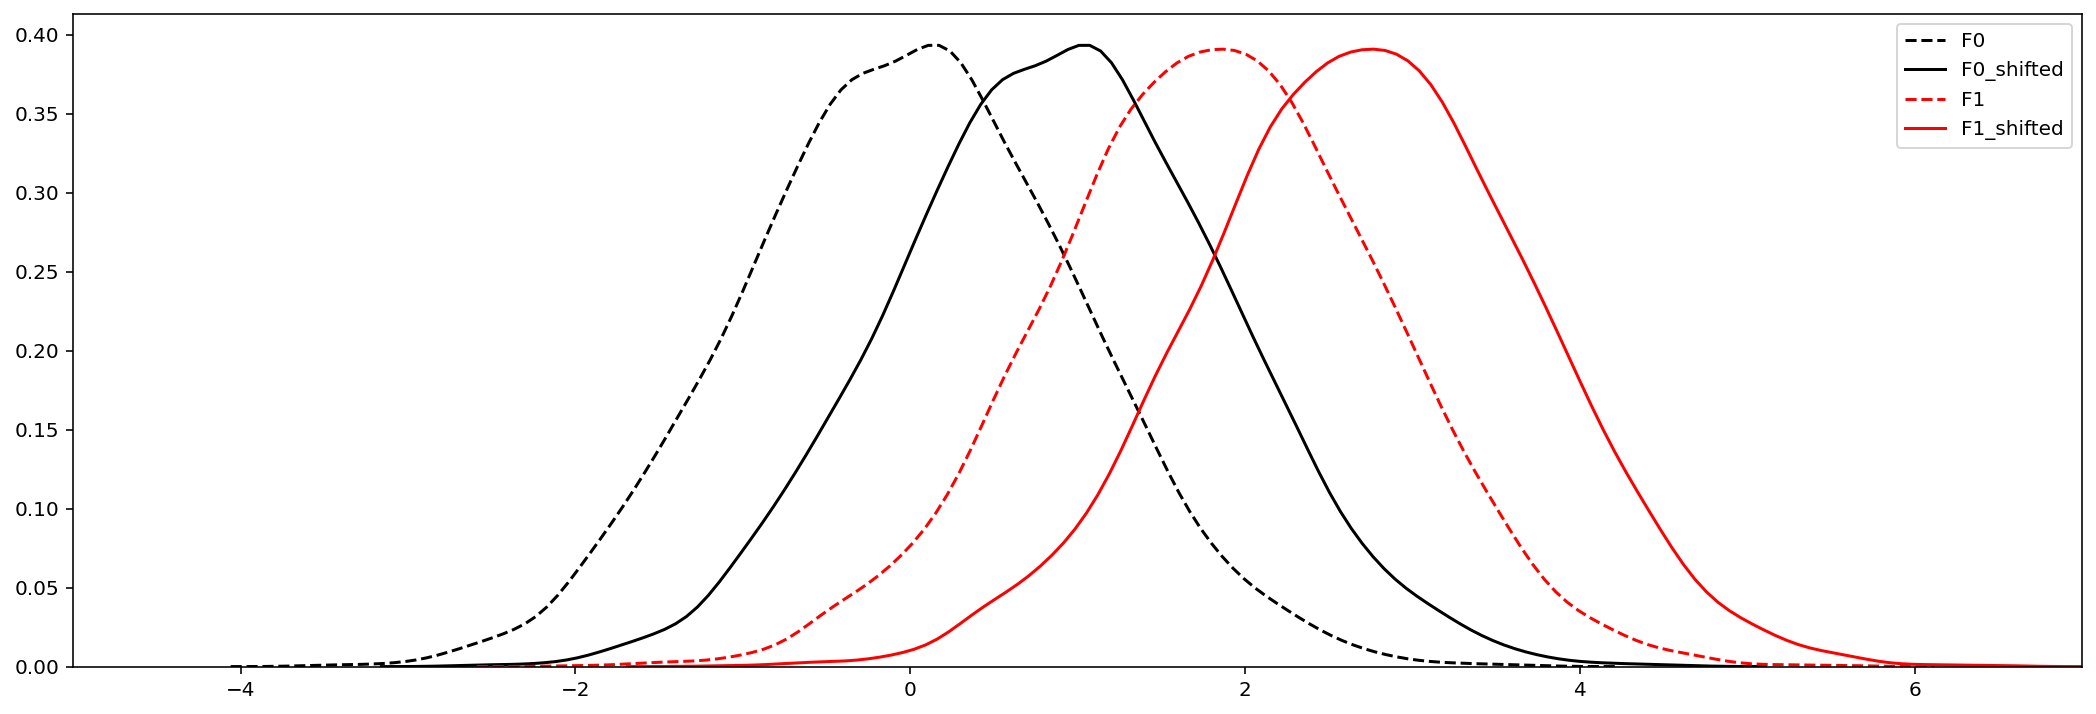

In [30]:
# plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sea.distplot(f0, hist=False, color='black', label='F0', kde_kws={'linestyle':'--'})
sea.distplot(f0_, hist=False, color='black', label='F0_shifted')
sea.distplot(f1, hist=False, color='red', label='F1', kde_kws={'linestyle':'--'})
sea.distplot(f1_, hist=False, color='red', label='F1_shifted')

ax.set_xlim(-5, 7)

In [25]:
kws

{'cumulative': True}

(-5.0, 7.0)

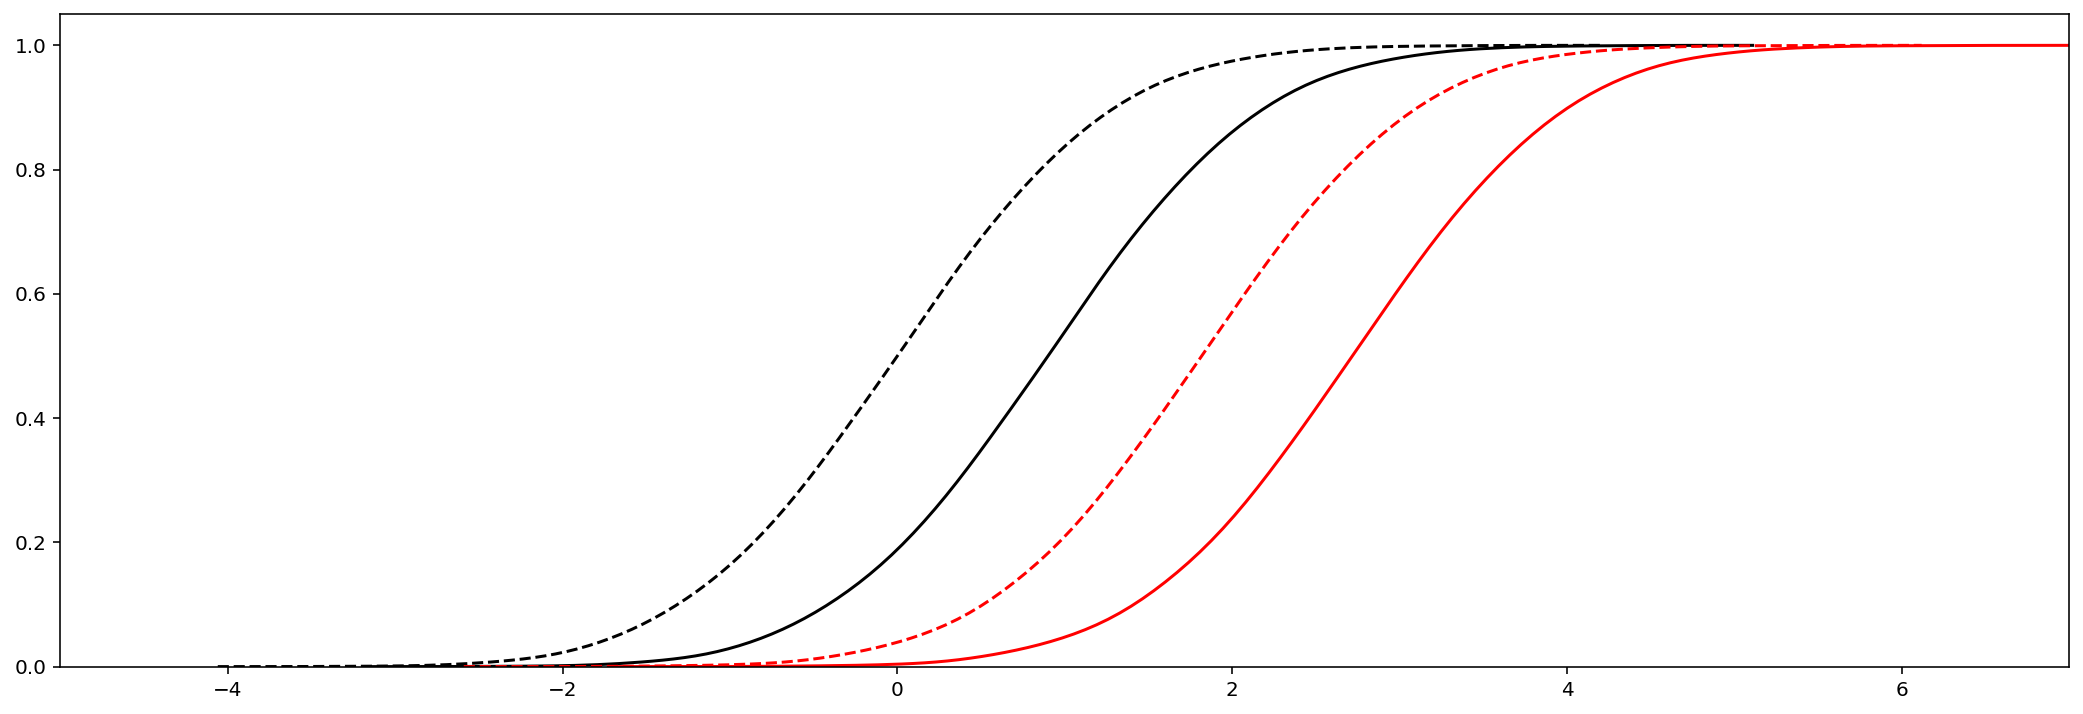

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

sea.distplot(f0, hist=False, color='black', kde_kws={'cumulative': True, 'linestyle':'--'})
sea.distplot(f0_, hist=False, color='black', kde_kws={'cumulative': True})
sea.distplot(f1, hist=False, color='red', kde_kws={'cumulative': True, 'linestyle':'--'})
sea.distplot(f1_, hist=False, color='red', kde_kws={'cumulative': True})

ax.set_xlim(-5, 7)

In [64]:
from scipy.stats import percentileofscore

In [68]:
from scipy import stats

def gen_cdf(mean, var, size=10000):
    """
    Inputs:
        mean (float): the mean of the gaussian distribution
        var (float): the variance of the gaussian distribution    
    Return:
        (np.ndarray): a sample from the gaussian distribution
        
    """
    return np.random.normal(mean, var, size)

def get_xi(f0, f1, mu_0, mu_1, fpr=0.8):
    """
    Inputs:
        f0, f1 (np.ndarray): samples from gaussian distributions
        mu_0, mu_1 (float): the magnitude of the shift for cdf
        fpr (float): the predefined false positive rate
        
    Return:
        xi (float): the calculated minus recall change   
    """
    # Set up distribution
    f0_ = f0 + mu_0
    f1_ = f1 + mu_1

    # Get threshold
    t_q = np.quantile(f0, fpr)
    t_tilde = np.quantile(f0_, fpr)

    # Get fnr
    q = percentileofscore(f1, t_tilde) / 100
    q_star = percentileofscore(f1_, t_tilde) / 100

    # Get xi
    xi = q - q_star
    
    return xi

def get_xi_approx(f0, f1, mu_0, mu_1, fpr=0.8):
    """
    Inputs:
        f0, f1 (np.ndarray): samples from gaussian distributions
        mu_0, mu_1 (float): the magnitude of the shift for cdf
        fpr (float): the predefined false positive rate
        
    Return:
        xi_approx (float): the calculated minus recall change by algorithm   
    """
    # Set up distribution
    f0_ = f0 + mu_0
    f1_ = f1 + mu_1

    # Get threshold
    t_q = np.quantile(f0, fpr)

    # Get recall change
    xi_approx = (percentileofscore(f1, t_q + mu_0) - percentileofscore(f1, t_q + mu_0 - mu_1)) / 100
    
    return xi_approx

In [76]:
f0 = gen_cdf(0.2, 1)
f1 = gen_cdf(0.4, 1.4)
mu_0 = 0.1
mu_1 = 0.2
xi = get_xi(f0, f1, mu_0, mu_1)
xi_approx = get_xi_approx(f0, f1, mu_0, mu_1)

In [77]:
xi

0.04870000000000008

In [78]:
xi_approx

0.04870000000000005

In [66]:
xi = (percentileofscore(f1, t_q + mu_0) - percentileofscore(f1, t_q + mu_0 - mu_1)) / 100

In [67]:
xi

0.3108

In [65]:
percentileofscore(f0, 0.84579724) / 100

0.8011

In [38]:
np.quantile(f0, 0.8)

0.8457972415307533

In [40]:
mu_0 = 0.9
mu_1 = 0.9
fpr = 0.8

In [51]:
# Set up distribution
f0 = np.random.normal(0, 1, 10000)
f1 = np.random.normal(1.8, 1, 10000)
f0_ = f0 + mu_0
f1_ = f1 + mu_1

# Get threshold
t_q = np.quantile(f0, fpr)
t_tilde = np.quantile(f0_, fpr)

# Get fnr
q = stats.percentileofscore(f1, t_tilde) / 100
q_star = stats.percentileofscore(f1_, t_tilde) / 100

# Get xi
xi = q - q_star

In [52]:
q - q_star

0.31079999999999997

In [62]:
# Set up distribution
f0_ = f0 + mu_0
f1_ = f1 + mu_1

# Get threshold
t_q = np.quantile(f0, fpr)

# Get recall change
xi = (stats.percentileofscore(f1, t_q + mu_0) / 100) - (stats.percentileofscore(f1, t_q + mu_0 - mu_1) / 100)

In [63]:
xi

0.31079999999999997